<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
!pip install -Uqq fastbook
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


In [179]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [181]:
auth.authenticate_user()

In [182]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [183]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
/
Operation completed over 1 objects/57.1 MiB.                                     


In [184]:
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    prevLoco = currentLoco
                            

1000   19:16:18
2000   19:16:31
3000   19:16:35
4000   19:16:42
5000   19:16:46
6000   19:16:53
7000   19:16:58
8000   19:17:02
9000   19:17:09
10000   19:17:13


In [185]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [186]:
del trains

In [187]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 0
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        10054 non-null  object 
 1   maximumTrainSpeed                                                          10053 non-null  float64
 2   loadedCarCount                                                             10053 non-null  float64
 3   emptyCarCount                                                              10053 non-null  float64
 4   trainLength                                                                10053 non-null  float64
 5   trailingTonnage                                                            10053 non-null  float64
 6   positionHistoryList                                       

In [188]:
dfTrainsLearn = dfTrainsAll
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['M', 'I', 'Z', 'C', 'W', 'E', 'U'])


In [189]:
def getWorkLocations(dfTrainsLocation):
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [190]:
#getWorkLocations(dfTrainsLearn.iloc[301])

In [191]:
#dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]

In [192]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [193]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '258.40,202.20', '202.20,258.40', '202.20,258.40,321.50', '202.92,202.20', '225.10,202.20', '240.90,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [194]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [195]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [196]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-04-21T23:34:11Z,-10,106,WEST MAIN,766.36030
1,2022-04-21T23:36:11Z,-10,106,MAIN,766.01776
2,2022-04-21T23:38:11Z,-9,106,MAIN,765.68665
3,2022-04-21T23:40:11Z,-8,106,MAIN,765.38310
4,2022-04-21T23:42:11Z,-9,106,MAIN,765.07520


In [197]:
def findNextSpeed(trainsEntry, actualsEntry):
  milepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  #print(milepost)
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > milepost+1]
  if (len(value) > 0):
    return (value.min()['speedMPH'] - trainsEntry['lastReportedPosition.speedMPH'])
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < milepost-1]
  if (len(value) > 0):
    return (value.max()['speedMPH'] - trainsEntry['lastReportedPosition.speedMPH'])
  return None

In [198]:
dfTrainsLearn['nextSpeed'] = dfTrainsLearn['lastReportedPosition.speedMPH']
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  actualsEntry = dfTrainsLearnActuals.iloc[i]
  nextSpeed = findNextSpeed(trainsEntry, actualsEntry)
  if (nextSpeed != None):
    trainsEntry['nextSpeed'] = nextSpeed
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [199]:
# dfTrainsLearn = dfTrainsLearn.drop(['hour'], axis=1)
dfTrainsLearn['nextSpeed'].unique()

array([-12, -11, -10,  -8, -56, -58, -55, -43, -29, -34,   0, -22, -28, -27, -65, -68, -70, -67, -64, -71, -69, -62, -59, -61, -66, -48, -50, -53, -60, -52, -47, -46, -38, -37, -51, -17, -36, -41,
       -63,  38,  50,  61,  62,  58,  59,  63,  67,  68,  69,  53,  39,  37,  41,  66,  64,  60,  65,  36,  46,  47,  49,  51,  48,  45,  54,  56,  55,  52,  70,  57,  43,  42, -45, -40, -49, -57,
       -54, -44, -39,  21,   9,   8,  27,  34,  31,  28,  35,  44,  24,  25,  26,  29,  30,  40,  23,  20,  11,  16,  32, -35, -32, -33, -31, -30, -25, -23, -26, -42, -20, -21, -19, -24, -16, -15,
        -5,  -9, -14, -13,  -2,  -7, -18,  -1,  -6,  22,  13,   6,   5,  33,  19,  17,  10,   7,   3,  14,  12,  15,  18,   2,   1,  -3,  -4,   4])

Drop some values we are not using at the moment not needed

In [200]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            'lastReportedPosition.nextSignalState.previousSignalState', 
                                            'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [201]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
...,...,...,...,...,...,...,...,...,...
0,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
0,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
0,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
0,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09


In [202]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(10054, 51)
(10054,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10054 entries, 0 to 0
Data columns (total 51 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   ptcLeadLocomotiveId                                                        10054 non-null  object        
 1   maximumTrainSpeed                                                          10053 non-null  float64       
 2   loadedCarCount                                                             10053 non-null  float64       
 3   emptyCarCount                                                              10053 non-null  float64       
 4   trainLength                                                                10053 non-null  float64       
 5   trailingTonnage                                                            10053 non-null  f

# Use Decision Tree to predict speed in 1 mile

In [203]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [204]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
90     124
91     271
92      79
93     106
95     109
      ... 
121     45
122    247
123    214
124    237
125    150
Name: lastReportedPosition.positionTimeDayofyear, Length: 33, dtype: int64


In [205]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 121 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [206]:
dep_var = 'nextSpeed'

In [207]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [208]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [209]:
len(to.train),len(to.valid)

(9161, 893)

In [210]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.ownershipCode,aotuTrainData.eventCode,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,maximumTrainSpeed_na,loadedCarCount_na,emptyCarCount_na,trainLength_na,trailingTonnage_na,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.precedingSignalState.previousSignalState_na,lastReportedPosition.precedingSignalState.signalState_na,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.nextSignalState.signalState_na,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-12,766.930420,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-12
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-11,766.718811,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-11
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.565308,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.435181,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.322815,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,-10
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-10,766.2897

In [211]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [212]:
to = fastai.load_pickle('/tmp/to.pkl')

In [213]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [339]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

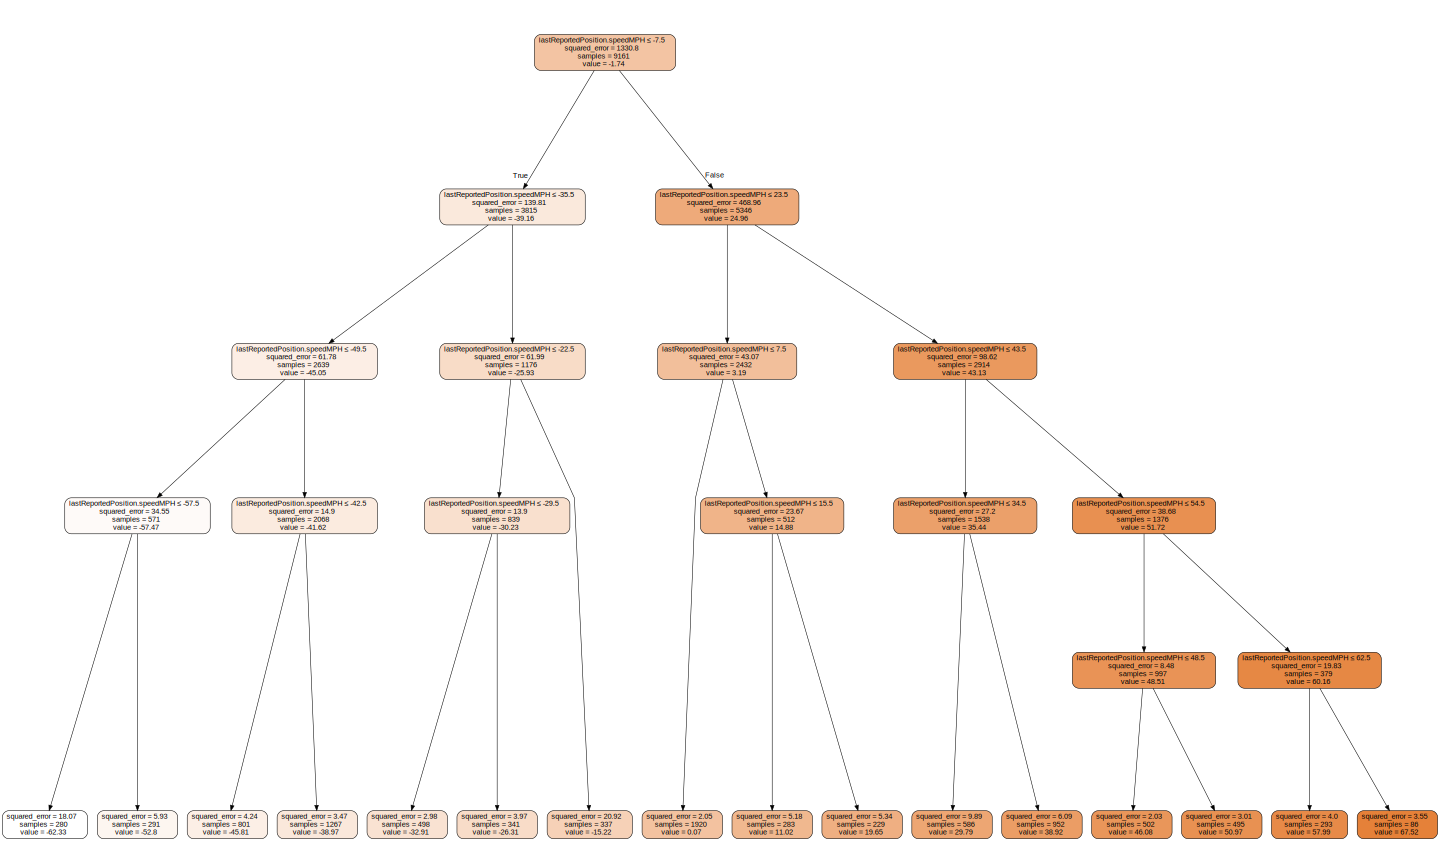

In [340]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [341]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [342]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [343]:
m_rmse(m, xs, y)

0.087185

In [344]:
m_rmse(m, valid_xs, valid_y)

0.173346

In [326]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [346]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
33,lastReportedPosition.speedMPH,9.999994e-01
32,trailingTonnage,2.614734e-07
34,lastReportedPosition.milepostLocation.milepost.milepostNumber,1.565187e-07
51,lastReportedPosition.nextSignalState.signalState,4.878263e-08
29,loadedCarCount,3.061496e-08
38,aotuTrainData.totalCarWeight,2.670004e-08
49,lastReportedPosition.precedingSignalState.signalState,1.324413e-08
50,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,5.177867e-09
52,milepost,4.101250e-09
0,ptcLeadLocomotiveId,2.903987e-09


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

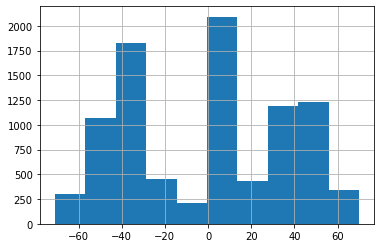

In [352]:
ax = xs['lastReportedPosition.speedMPH'].hist()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


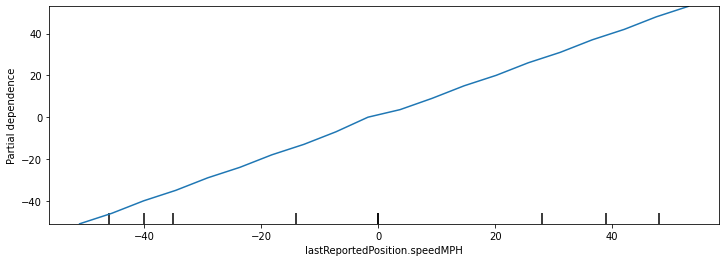

In [353]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [315]:
def randomForest(xs, y, n_estimators=50, max_samples=1500,
       max_features=0.6, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [316]:
m = randomForest(xs, y);

In [317]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.707943, 1.102309)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

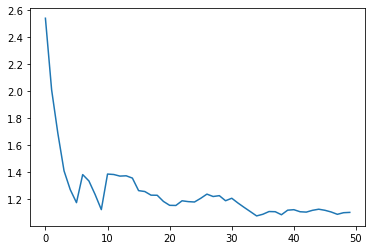

In [320]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [321]:
r_mse(m.oob_prediction_, y)

0.761377

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [323]:
preds.shape

(50, 893)

In [324]:
preds_std = preds.std(0)

In [325]:
preds_std[:5]

array([3.60806304, 3.72033919, 3.62327066, 2.0375765 , 2.1497783 ])

# FEATURE Importance

In [331]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
33,lastReportedPosition.speedMPH,0.687563
51,lastReportedPosition.nextSignalState.signalState,0.227394
49,lastReportedPosition.precedingSignalState.signalState,0.037662
48,lastReportedPosition.precedingSignalState.previousSignalState,0.012177
0,ptcLeadLocomotiveId,0.008548
35,aotuTrainData.priorityCode,0.005297
3,trainId.trainSymbol,0.004946
24,lastReportedPosition.precedingSignalState.previousSignalState_na,0.004615
6,lastReportedPosition.milepostLocation.trackName,0.002840
34,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.001451


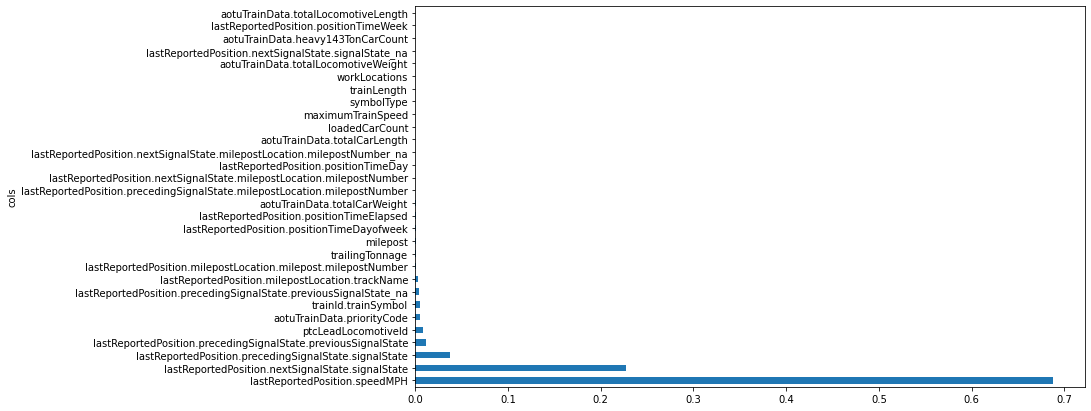

In [328]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [332]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

19

In [333]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [334]:
m = randomForest(xs_imp, y)

In [335]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.806844, 1.467372)

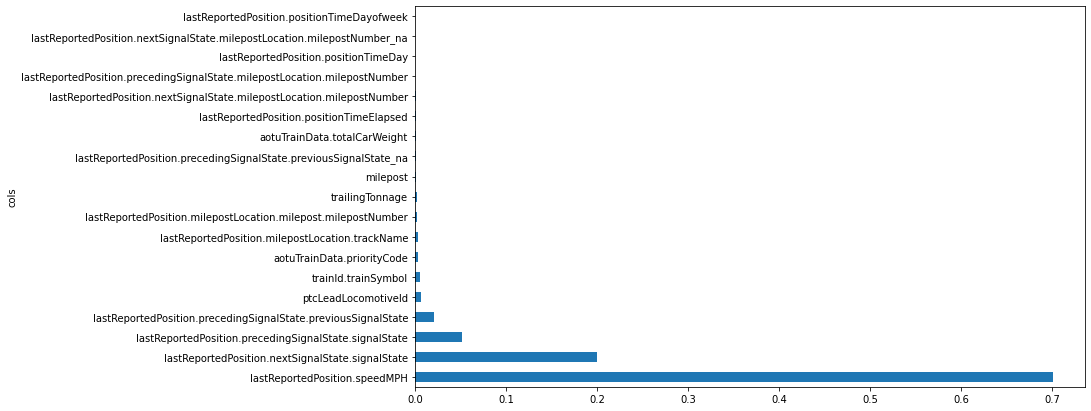

In [336]:
plot_fi(rf_feat_importance(m, xs_imp));

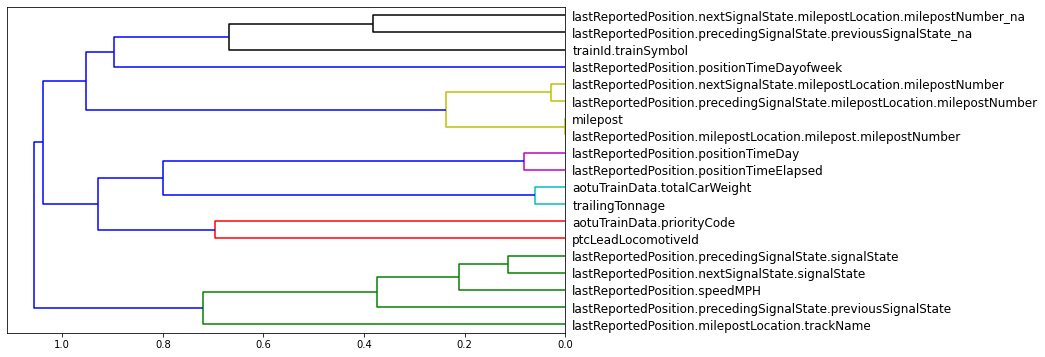

In [338]:
fastai.cluster_columns(xs_imp)